# Tratamento de dados

Esse script demonstra os testes realizados para escolher o melhor tratamento de dados e aplicá-los no dataset

-------------------------------------------------------------------------------

### Base de dados: Operações de Cartão de Crédito

kaggle.com/mlg-ulb/creditcardfraud

284,807 instâncias sem fraude
492 instâncias com fraude

30 atributos

2 classes (com frause, sem fraude)


--------------------------------------------------------------------------------
Trabalho de Conclusão de Curso apresentado ao Curso de Especialização em Inteligência Artificial e Aprendizado de Máquina como requisito parcial à obtenção do título de especialista.
Eloyza Maria S. B. Generozo

In [ ]:
## instalação

!pip install pydotplus
!pip install imblearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

from collections import Counter

In [2]:
###### Verificando se a base possui valores ausentes ##############

creditcard = pd.read_csv('creditcard.csv') 
creditcard.isnull().values.any()

False

In [3]:
###### Verificando se os campos Amount e Time precisam de normalização ##############

print (len(creditcard))

print(creditcard['Amount'].skew())
print(creditcard['Amount'].describe())


print(creditcard['Time'].skew())
print(creditcard['Time'].describe())

284807
16.977724453761024
count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64
-0.0355676180063216
count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64


In [4]:
###### Normalizando campos Amount e Time ##############

creditcard['Amount'] = preprocessing.RobustScaler().fit_transform(creditcard['Amount'].values.reshape(-1, 1))
creditcard['Time'] = preprocessing.MinMaxScaler().fit_transform(creditcard['Time'].values.reshape(-1, 1))

creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,0
2,0.000006,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,0
3,0.000006,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,0
4,0.000012,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,0


Class 0 - Não Fraudulenta: 284315
Class 1 - Fraudulenta: 492


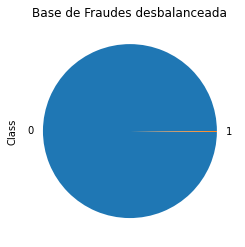

In [5]:
###### Avaliando balanceamento da base ##############

target_count = creditcard.iloc[:,-1].value_counts()
print('Class 0 - Não Fraudulenta:', target_count[0])
print('Class 1 - Fraudulenta:', target_count[1])
target_count.plot(kind='pie', title='Base de Fraudes desbalanceada');


In [6]:

###### Criando função de classificação com Decision Tree para avaliar técnicas de balanceamento ##############

def obtemMetricasDecisionTree(X, y, nome_tecnica):
    # Separando base de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
       X, 
       y, 
       test_size=0.3, 
       random_state=1)

    model = DecisionTreeClassifier()


    # Treinando modelo
    model.fit(X_train, y_train)

    # Iniciando predição
    y_pred = model.predict(X_test)

    # Obtendo metricas
    print("Acurácia de previsão - " + nome_tecnica, accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=["Normal", "Fraude"]))

    # Matriz de Consufão
    cnf_matrix = confusion_matrix(y_test, y_pred)
    cnf_table = pd.DataFrame(data=cnf_matrix, index=["Normal", "Fraude"], columns=["Normal (prev)", "Fraude (prev)"])
    print(cnf_table)
    plt.matshow(cnf_matrix)
    plt.colorbar()
    plt.ylabel('Real Class')
    plt.xlabel('Predicted Class')
    plt.show()
    
    # Curva AOC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, color='blue',label='ROC (AUC = %0.4f)' % auc)
    plt.legend(loc='lower right')
    plt.title("ROC Curve " + nome_tecnica)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()

## Avaliando métricas antes do Balanceamento

Podemos ver abaixo que a acurácia está bem alta, porém analisando o gráfico de matriz de confusão vemos que a classificação está toda concentrada em uma classe: a majoritária, isso gera um overfiting sobre essa classe, dando a falsa sensação de uma boa performance.

Acurácia de previsão -  0.9990988144142879
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85308
      Fraude       0.71      0.72      0.72       135

    accuracy                           1.00     85443
   macro avg       0.86      0.86      0.86     85443
weighted avg       1.00      1.00      1.00     85443

        Normal (prev)  Fraude (prev)
Normal          85269             39
Fraude             38             97


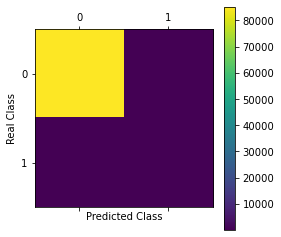

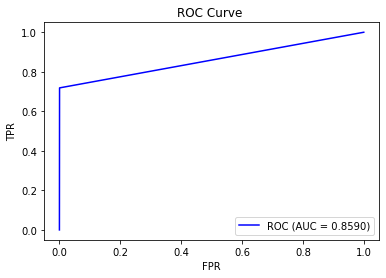

In [8]:
###### Avaliando métricas sem aplicar nenhuma técnica de balanceamento ##############


X = creditcard.iloc[:,0:(creditcard.shape[1] - 1)]
le = LabelEncoder()
y = le.fit_transform(creditcard.iloc[:,(creditcard.shape[1] - 1)])

obtemMetricasDecisionTree(X, y, '')

## Técnicas de Balanceamento que serão avaliadas

<b>Random Over-Sampling:</b> A opção mais simples de sobre-amostragem aleatória, na qual duplicamos aleatoriamente os pontos de dados dentro da classe minoritária até que ambas as classes tenham o mesmo tamanho. Abaixo podemos ver a base balanceada, mantendo todos os registros originais da classe majoritária. Porém, também vemos que no resultado da classificação, devido a classe minoritária ser duplicada continuamente, temos uma classificação sem nenhuma generalização e aumento de overfiting.

<b>Random Under-Sampling:</b> Nesta sub-amostragem simplesmente escolhemos pontos de dados aleatórios de dentro da classe majoritária e os excluímos até que ambas as classes tenham o mesmo tamanho. Temos um resultado mais distribuído na matriz de confusão e uma acurácia mais real, porém, conforme gráfico abaixo, ficamos com uma base pequena e bem limitada, perdendo muitos dados para que a quantidade igualasse com a minoritária.

<b>SMOTE (Synthetic Minority Over-sampling Technique):</b> O SMOTE gera novos pontos para a classe minoritária selecionando exemplos próximos. Especificamente, um exemplo aleatório da classe minoritária é escolhido primeiro. Então, k dos vizinhos mais próximos para esse exemplo são encontrados (normalmente k = 5). Um vizinho selecionado aleatoriamente é escolhido e um exemplo sintético é criado em um ponto selecionado aleatoriamente entre os dois exemplos no espaço de recursos. Para esta técnica, podemos ver que a distribuição da matriz de confusão continua diagonal e tivemos uma melhoria nas métricas, mantendo também a quantidade total de registros permitindo que o modelo consiga generalizar. Para demonstrar a geração desses pontos sintéticos, abaixo há gráficos de dispersão com o antes e depois de executar o SMOTE no dataset.

<b>Tomek: </b>O algoritmo Tomek Links remove dados da classe majoritária que possui links tomek. Um link tomek é definido como dados de classes diferentes que são vizinhas mais próximas umas das outras. Este método sozinho, teve o pior resultado, pois os dados removidos não foram suficientes para balancear.

<b>SMOTE + Tomek: </b>Essa alternativa mista apresentou os melhores resultados, pois combina o Over Sampling gerando dados sintéticos usando SMOTE e a limpeza de dados da classe majoritária usando o Tomek. Dado esse resultado, essa alternativa foi escolhida para aplicar os modelos de machine learning de classificação.

Random over-sampling:
1    284315
0    284315
Name: Class, dtype: int64
Acurácia de previsão - Random Over Sampling 0.9997303460363799
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85175
      Fraude       1.00      1.00      1.00     85414

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589

        Normal (prev)  Fraude (prev)
Normal          85129             46
Fraude              0          85414


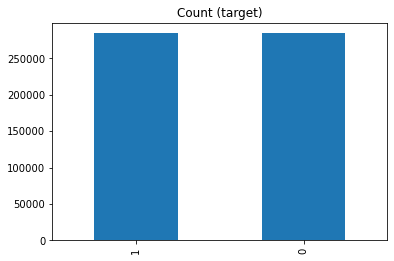

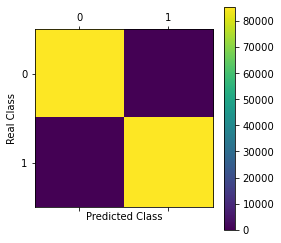

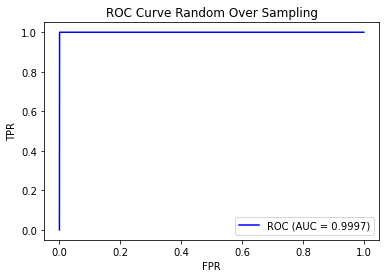

In [9]:

###### Avaliando técnica Random Oversampling ##############

### obtendo indices de cada classe ####
target_0 = creditcard[creditcard.Class == 0]
target_1 = creditcard[creditcard.Class == 1]

target_1_oversample = target_1.sample(len(target_0), replace=True)
test_oversample = pd.concat([target_1_oversample, target_0], axis=0)

# Quantidades e gráfico após balanceamento
print('Random over-sampling:')
print(test_oversample.iloc[:,-1].value_counts())
test_oversample.iloc[:,-1].value_counts().plot(kind='bar', title='Count (target)');

X = test_oversample.iloc[:,0:(test_oversample.shape[1] - 1)]

## convertendo para labels únicos e sequencias
le = LabelEncoder()
y = le.fit_transform(test_oversample.iloc[:,(test_oversample.shape[1] - 1)]) 

obtemMetricasDecisionTree(X, y, 'Random Over Sampling')

Random under-sampling:
1    492
0    492
Name: Class, dtype: int64
Acurácia de previsão - Random Over Sampling 0.8952702702702703
              precision    recall  f1-score   support

      Normal       0.88      0.90      0.89       142
      Fraude       0.91      0.89      0.90       154

    accuracy                           0.90       296
   macro avg       0.90      0.90      0.90       296
weighted avg       0.90      0.90      0.90       296

        Normal (prev)  Fraude (prev)
Normal            128             14
Fraude             17            137


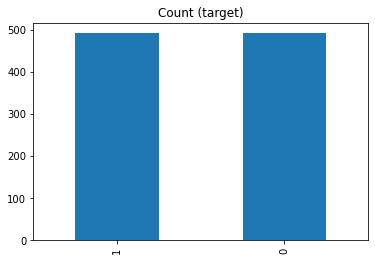

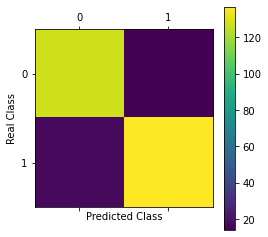

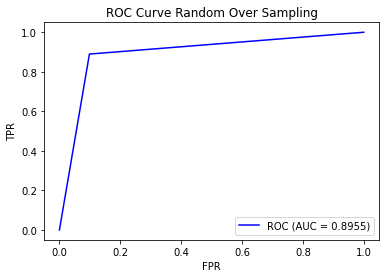

In [10]:
###### Avaliando técnica Random Undersampling ##############

### obtendo indices de cada classe ####
target_0 = creditcard[creditcard.Class == 0]
target_1 = creditcard[creditcard.Class == 1]

target_0_undersample = target_0.sample(len(target_1))
test_undersample = pd.concat([target_0_undersample, target_1], 
                             axis=0)
# Quantidades e gráfico após balanceamento
print('Random under-sampling:')
print(test_undersample.iloc[:,-1].value_counts())
test_undersample.iloc[:,-1].value_counts().plot(kind='bar', title='Count (target)');

## convertendo para labels únicos e sequencias
le = LabelEncoder()

X = test_undersample.iloc[:,0:(test_undersample.shape[1] - 1)]
y = le.fit_transform(test_undersample.iloc[:,(test_undersample.shape[1] - 1)]) 
obtemMetricasDecisionTree(X, y, 'Random Over Sampling')

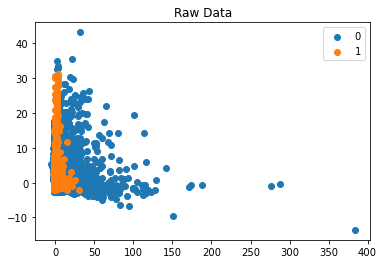

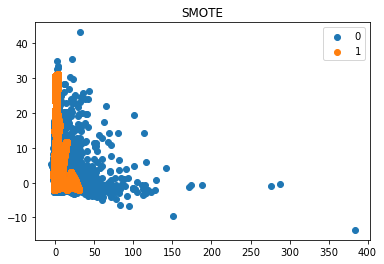

Acurácia de previsão - SMOTE 0.9557474397528563
              precision    recall  f1-score   support

      Normal       0.96      0.95      0.96     85428
      Fraude       0.95      0.96      0.96     85161

    accuracy                           0.96    170589
   macro avg       0.96      0.96      0.96    170589
weighted avg       0.96      0.96      0.96    170589

        Normal (prev)  Fraude (prev)
Normal          80905           4523
Fraude           3026          82135


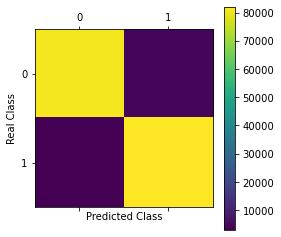

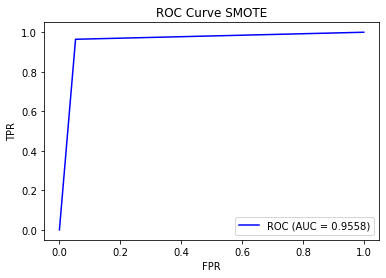

In [12]:
###### Avaliando técnica SMOTE ##############

X = creditcard.iloc[:,0:(creditcard.shape[1] - 1)]
le = LabelEncoder()
y = le.fit_transform(creditcard.iloc[:,(creditcard.shape[1] - 1)]) 

# Definindo PCA model para melhor perfomance bidimensional
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)


# Definindo função que plota grafico de dispersao
def draw_plot(X, y, label):
    for l in np.unique(y):
        plt.scatter(X[y==l, 0], X[y==l, 1], label=l)
    plt.title(label)
    plt.legend()
    plt.show()

# Plotando grafico com pontos antes de aplicar técnica    
draw_plot(X_2d, y, 'Raw Data')    
    
# Definindo SMOTE model e especificando classe 'minority' para repor a classe de fraude
sm = SMOTE(sampling_strategy='minority', k_neighbors=4) 
X_smote, y_smote = sm.fit_sample(X_2d, y)

# Plotando grafico com pontos depois de aplicar técnica
draw_plot(X_smote, y_smote, 'SMOTE')

obtemMetricasDecisionTree(X_smote, y_smote, 'SMOTE')


Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 284073, 1: 492})


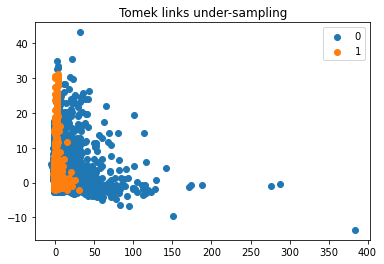

Acurácia de previsão - Tomek 0.9973058451446644
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85204
      Fraude       0.27      0.23      0.25       166

    accuracy                           1.00     85370
   macro avg       0.63      0.61      0.62     85370
weighted avg       1.00      1.00      1.00     85370

        Normal (prev)  Fraude (prev)
Normal          85102            102
Fraude            128             38


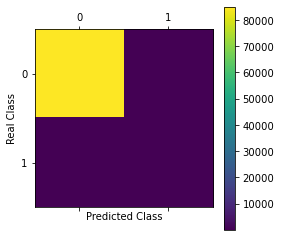

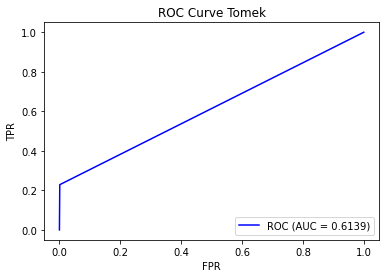

In [13]:
###### Avaliando técnica Tomek ##############

X = creditcard.iloc[:,0:(creditcard.shape[1] - 1)]
y = le.fit_transform(creditcard.iloc[:,(creditcard.shape[1] - 1)]) 

# Definindo PCA model para melhor perfomance bidimensional
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)


tome = TomekLinks(sampling_strategy='auto')
X_tome, y_tome = tome.fit_sample(X_2d, y)

print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_tome)))
# Plotando grafico com pontos depois de aplicar técnica
draw_plot(X_tome, y_tome, 'Tomek links under-sampling')

obtemMetricasDecisionTree(X_tome, y_tome, 'Tomek')


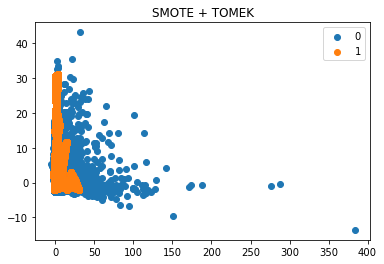

Acurácia de previsão - SMOTE + Tomek 0.9617883343284288
              precision    recall  f1-score   support

      Normal       0.97      0.95      0.96     84722
      Fraude       0.95      0.97      0.96     84441

    accuracy                           0.96    169163
   macro avg       0.96      0.96      0.96    169163
weighted avg       0.96      0.96      0.96    169163

        Normal (prev)  Fraude (prev)
Normal          80778           3944
Fraude           2520          81921


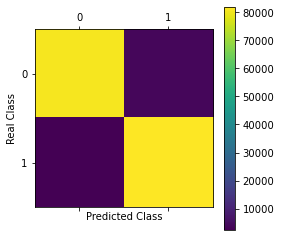

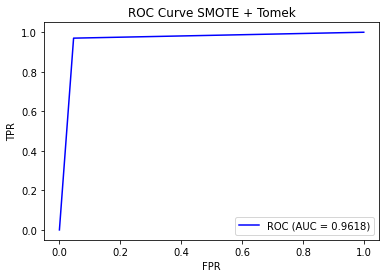

In [14]:
###### Avaliando técnica SMOTE + Tomek ##############

X = creditcard.iloc[:,0:(creditcard.shape[1] - 1)]
y = le.fit_transform(creditcard.iloc[:,(creditcard.shape[1] - 1)]) 

# Definindo PCA model para melhor perfomance bidimensional
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

sm = SMOTE(sampling_strategy='minority', k_neighbors=4) 
smto = SMOTETomek(sampling_strategy='auto', smote=sm)

X_smto, y_smto = smto.fit_sample(X_2d, y)
# Plotando grafico com pontos depois de aplicar técnica
draw_plot(X_smto, y_smto, 'SMOTE + TOMEK')

obtemMetricasDecisionTree(X_smto, y_smto, 'SMOTE + Tomek')

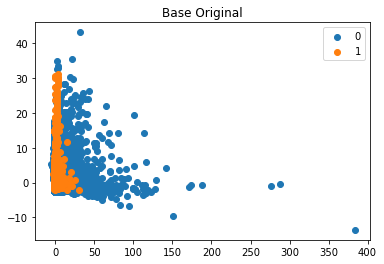

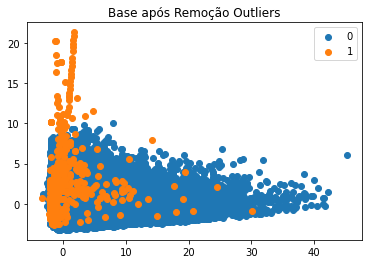

In [15]:
###### Removendo Outliers da Classe 0 ##############

# Definindo PCA model para melhor perfomance tridimensional
pca = PCA(n_components=3)
le = LabelEncoder()

X = creditcard.iloc[:,0:(creditcard.shape[1] - 1)]
y = le.fit_transform(creditcard.iloc[:,(creditcard.shape[1] - 1)]) 

X_3d = pca.fit_transform(X)
draw_plot(X_3d, y, 'Base Original')    

# Removendo outliers apenas das classes 0
iso_forest = IsolationForest(contamination=0.01, random_state=1)
target_0 = creditcard[creditcard.Class == 0]
target_1 = creditcard[creditcard.Class == 1]
iso_forest = iso_forest.fit(target_0)
sof_outliers = iso_forest.predict(target_0)
target_0 = target_0[sof_outliers != -1]

# Juntando novamente classe 0 com 1
creditcard = pd.concat([target_0, target_1], axis=0)

X = creditcard.iloc[:,0:(creditcard.shape[1] - 1)]
y = le.fit_transform(creditcard.iloc[:,(creditcard.shape[1] - 1)]) 

X_3d = pca.fit_transform(X)
draw_plot(X_3d, y, 'Base após Remoção Outliers')    
